In [155]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [156]:
df = pd.read_csv(r'C:\Users\nico_\Desktop\series_temporelles\AEP_hourly.csv')

In [157]:
df["Datetime"] = pd.to_datetime(df["Datetime"])

In [158]:
df = df.sort_values(by="Datetime")

In [159]:
df = df.set_index('Datetime')

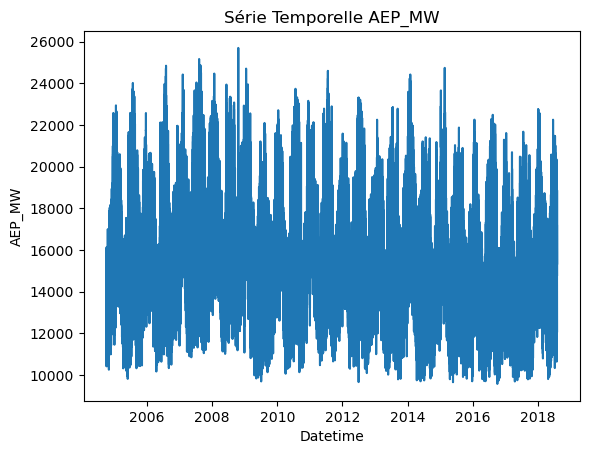

In [160]:
plt.plot(df.index, df['AEP_MW'])
plt.xlabel('Datetime')
plt.ylabel('AEP_MW')
plt.title('Série Temporelle AEP_MW')
plt.show()

In [161]:
df2 = df.resample('M').mean()

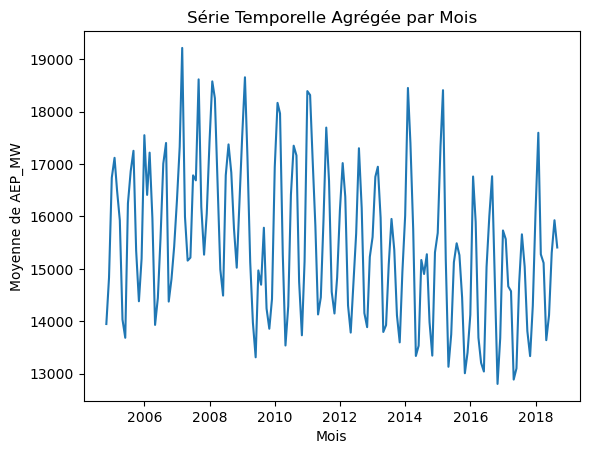

In [162]:
plt.plot(df2.index, df2['AEP_MW'])
plt.xlabel('Mois')
plt.ylabel('Moyenne de AEP_MW')
plt.title('Série Temporelle Agrégée par Mois')
plt.show()

In [163]:
split_time = (len(df2["AEP_MW"]) * 70)/100
split_time

116.9

In [164]:
split_time = 116

# Train
time_train = df2.index[:split_time]
x_train = df2["AEP_MW"][:split_time]

# Validation
time_val = df2.index[split_time:]
x_val = df2["AEP_MW"][split_time:]

In [165]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train.values.reshape(-1, 1))

x_val_scaled = scaler.transform(x_val.values.reshape(-1, 1))

In [166]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 100

In [167]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size +1, shift = 1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size +1))
    dataset = dataset.map(lambda window: (window[:-1],window[-1]))
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [168]:
dataset = windowed_dataset(x_train_scaled, window_size, batch_size, shuffle_buffer_size)

In [169]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [170]:
# Set the learning rate
learning_rate = 2e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)


In [171]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [172]:
# Train the model
history = model.fit(dataset,epochs=1000)

Epoch 1/1000
3/3 [==============================] - 10s 82ms/step - loss: 2.1153 - mae: 2.5767
Epoch 2/1000
3/3 [==============================] - 0s 22ms/step - loss: 1.9963 - mae: 2.4649
Epoch 3/1000
3/3 [==============================] - 0s 21ms/step - loss: 1.8142 - mae: 2.2673
Epoch 4/1000
3/3 [==============================] - 0s 21ms/step - loss: 1.7510 - mae: 2.2215
Epoch 5/1000
3/3 [==============================] - 0s 24ms/step - loss: 1.6914 - mae: 2.1405
Epoch 6/1000
3/3 [==============================] - 0s 21ms/step - loss: 1.6748 - mae: 2.1180
Epoch 7/1000
3/3 [==============================] - 0s 21ms/step - loss: 1.6186 - mae: 2.0620
Epoch 8/1000
3/3 [==============================] - 0s 21ms/step - loss: 1.5423 - mae: 1.9919
Epoch 9/1000
3/3 [==============================] - 0s 21ms/step - loss: 1.4597 - mae: 1.9205
Epoch 10/1000
3/3 [==============================] - 0s 21ms/step - loss: 1.4099 - mae: 1.8707
Epoch 11/1000
3/3 [==============================] - 0s 21

In [173]:
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [174]:
df2["AEP_MW_scaled"] = scaler.fit_transform(df2['AEP_MW'].values.reshape(-1, 1))

In [175]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

2/2 [==============================] - 2s 52ms/step


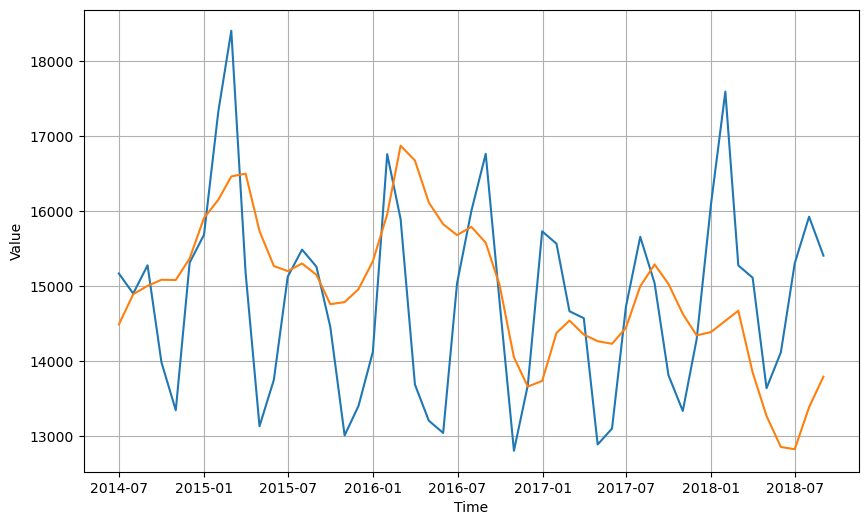

In [176]:
# Reduce the original series
forecast_series = df2['AEP_MW_scaled'][split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()
results = results.reshape(-1, 1)
results_original = scaler.inverse_transform(results)

# Plot the results
plot_series(time_val, (x_val, results_original))

In [177]:
mse = tf.keras.metrics.mean_squared_error(x_val, results_original).numpy()
mae = tf.keras.metrics.mean_absolute_error(x_val, results_original).numpy()

In [178]:
print("Mean Squared Error (MSE) Mean:", np.mean(mse))
print("Mean Absolute Error (MAE) Mean:", np.mean(mae))

Mean Squared Error (MSE) Mean: 2486294.0
Mean Absolute Error (MAE) Mean: 1262.3727
